# Cybersecurity Threat Detection

### Abstract

In this project, we address the critical task of anomaly detection in network traffic using the UNSW-NB15 dataset. Network anomalies can indicate malicious activities such as cyber-attacks, making their detection vital for cybersecurity.

We preprocess the data by encoding categorical variables and scaling features to normalize the dataset. To enhance model performance and reduce computational complexity, we employ feature selection using a Random Forest classifier to identify the most significant features. We implement and compare four machine learning models: Random Forest, XGBoost, LightGBM, and a Neural Network. Each model undergoes hyperparameter tuning to optimize its performance. The models are evaluated using classification metrics and ROC curves to determine their effectiveness in accurately detecting anomalies within the network traffic data.

### Load Data and Import Libraries

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np

# For Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# For Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# For Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold

# For Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


2024-11-19 19:59:55.483781: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the training and testing datasets
train_data = pd.read_csv('Data/UNSW_NB15_training-set.csv')
test_data = pd.read_csv('Data/UNSW_NB15_testing-set.csv')

# Combine train and test data for consistent preprocessing
full_data = pd.concat([train_data, test_data], ignore_index=True)

# Remove 'id' and 'attack_cat' columns if present
full_data.drop(columns=['id', 'attack_cat'], errors='ignore', inplace=True)


### Data Cleaning

In [3]:
# Identify categorical columns
categorical_cols = ['proto', 'service', 'state']

# Encode categorical variables using LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    full_data[col] = le.fit_transform(full_data[col])

# Separate the target variable 'label' from features
labels = full_data['label']
features = full_data.drop('label', axis=1)

# Scale features using StandardScaler for normalization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


### Preparing the Data

In [4]:
# Determine the original training set size
train_size = train_data.shape[0]

# Split features and labels back into training and test sets
X = features_scaled[:train_size]
X_test = features_scaled[train_size:]
y = labels[:train_size].values
y_test = labels[train_size:].values

# Further split the training data into training and validation sets
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Feature Selection

In [5]:
# Use a Random Forest to compute feature importances
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_full, y_train_full)
importances = rf_selector.feature_importances_

# Get indices of features sorted by importance
indices = np.argsort(importances)[::-1]

# Select the top N features based on importance
top_n = 40
selected_indices = indices[:top_n]

# Subset the training, validation, and test data with selected features
X_train = X_train_full[:, selected_indices]
X_val = X_val[:, selected_indices]
X_test_selected = X_test[:, selected_indices]


### Model Implementation

#### A. Random Forest Classifier

In [6]:
print("Training Random Forest Classifier...")

# Define the hyperparameter grid for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 20, 30, 40],
    'max_features': ['sqrt'],  # Use 'sqrt' to avoid deprecation warnings
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Classifier with balanced class weights
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Perform hyperparameter tuning using RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist_rf,
    n_iter=10,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
random_search_rf.fit(X_train, y_train_full)
best_rf = random_search_rf.best_estimator_
print("Best parameters found for Random Forest:", random_search_rf.best_params_)

# Retrain the best model on the training data
best_rf.fit(X_train, y_train_full)

# Predict on the validation set
y_val_pred_rf = best_rf.predict(X_val)
print("\nRandom Forest Validation Performance:")
print(classification_report(y_val, y_val_pred_rf))

# Predict on the test set
y_pred_rf = best_rf.predict(X_test_selected)


Training Random Forest Classifier...
Best parameters found for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

Random Forest Validation Performance:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11200
           1       0.97      0.97      0.97     23869

    accuracy                           0.96     35069
   macro avg       0.95      0.95      0.95     35069
weighted avg       0.96      0.96      0.96     35069



#### B. XGBoost Classifier

In [ ]:
print("\nTraining XGBoost Classifier...")

# Define the hyperparameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'scale_pos_weight': [1, 2, 5]
}

# Initialize the XGBoost Classifier
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Perform hyperparameter tuning using RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
random_search_xgb.fit(X_train, y_train_full)
best_xgb = random_search_xgb.best_estimator_
print("Best parameters found for XGBoost:", random_search_xgb.best_params_)

# Predict on the validation set
y_val_pred_xgb = best_xgb.predict(X_val)
print("\nXGBoost Validation Performance:")
print(classification_report(y_val, y_val_pred_xgb))

# Predict on the test set
y_pred_xgb = best_xgb.predict(X_test_selected)




Training XGBoost Classifier...


/Users/ericluong/opt/anaconda3/envs/tf/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ericluong/opt/anaconda3/envs/tf/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ericluong/opt/anaconda3/envs/tf/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ericluong/opt/anaconda3/envs/tf/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:02:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encod

Best parameters found for XGBoost: {'subsample': 1, 'scale_pos_weight': 2, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1}

XGBoost Validation Performance:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     11200
           1       0.95      0.99      0.97     23869

    accuracy                           0.96     35069
   macro avg       0.96      0.94      0.95     35069
weighted avg       0.96      0.96      0.96     35069



#### C. LightGBM Classifier

In [8]:
print("\nTraining LightGBM Classifier...")

# Define the hyperparameter grid for LightGBM
param_dist_lgb = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'class_weight': ['balanced', None]
}

# Initialize the LightGBM Classifier
lgb_classifier = LGBMClassifier(
    objective='binary',
    random_state=42,
    n_jobs=-1
)

# Perform hyperparameter tuning using RandomizedSearchCV
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_classifier,
    param_distributions=param_dist_lgb,
    n_iter=10,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=3),
    random_state=42,
    n_jobs=-1
)

# Fit the model to the training data
random_search_lgb.fit(X_train, y_train_full)
best_lgb = random_search_lgb.best_estimator_
print("Best parameters found for LightGBM:", random_search_lgb.best_params_)

# Predict on the validation set
y_val_pred_lgb = best_lgb.predict(X_val)
print("\nLightGBM Validation Performance:")
print(classification_report(y_val, y_val_pred_lgb))

# Predict on the test set
y_pred_lgb = best_lgb.predict(X_test_selected)




Training LightGBM Classifier...
[LightGBM] [Info] Number of positive: 63648, number of negative: 29867
[LightGBM] [Info] Number of positive: 63648, number of negative: 29866
[LightGBM] [Info] Number of positive: 63648, number of negative: 29866
[LightGBM] [Info] Number of positive: 63648, number of negative: 29866
[LightGBM] [Info] Number of positive: 63648, number of negative: 29867
[LightGBM] [Info] Number of positive: 63648, number of negative: 29867
[LightGBM] [Info] Number of positive: 63648, number of negative: 29866
[LightGBM] [Info] Number of positive: 63648, number of negative: 29867
[LightGBM] [Info] Number of positive: 63648, number of negative: 29867
[LightGBM] [Info] Number of positive: 63648, number of negative: 29867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 59

#### D. Neural Network Classifier

In [9]:
print("\nTraining Neural Network Classifier...")

# Initialize the neural network model
model_nn = Sequential()
model_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(32, activation='relu'))
model_nn.add(Dropout(0.5))
model_nn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
model_nn.fit(X_train, y_train_full, epochs=10, batch_size=256, validation_data=(X_val, y_val), verbose=0)

# Predict probabilities on the validation set
y_val_pred_nn_prob = model_nn.predict(X_val)
# Convert probabilities to binary predictions
y_val_pred_nn = (y_val_pred_nn_prob > 0.5).astype(int).reshape(-1)
print("\nNeural Network Validation Performance:")
print(classification_report(y_val, y_val_pred_nn))

# Predict on the test set
y_pred_nn_prob = model_nn.predict(X_test_selected)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).reshape(-1)



Training Neural Network Classifier...


2024-11-19 20:03:26.486178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1096/1096 [==============================] - 1s 439us/step

Neural Network Validation Performance:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     11200
           1       0.93      0.99      0.96     23869

    accuracy                           0.94     35069
   macro avg       0.95      0.91      0.93     35069
weighted avg       0.94      0.94      0.94     35069

2573/2573 [==============================] - 1s 440us/step


### Model Evaluation and Comparison

In [10]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc



Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.76      0.86     37000
           1       0.84      0.98      0.90     45332

    accuracy                           0.88     82332
   macro avg       0.90      0.87      0.88     82332
weighted avg       0.90      0.88      0.88     82332



<Figure size 800x600 with 0 Axes>

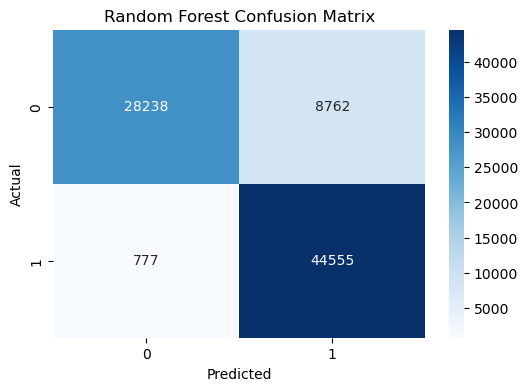


XGBoost Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     37000
           1       0.79      0.99      0.88     45332

    accuracy                           0.85     82332
   macro avg       0.88      0.83      0.84     82332
weighted avg       0.87      0.85      0.84     82332



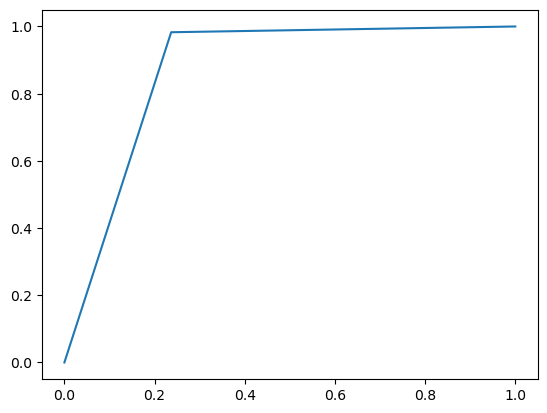

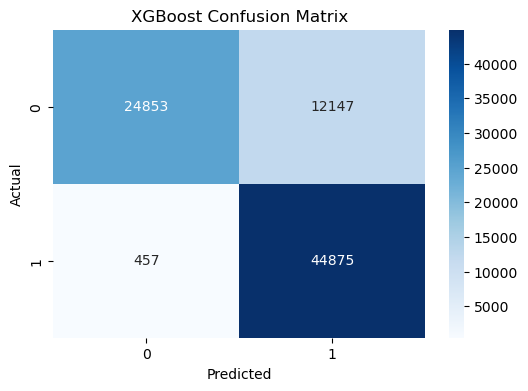


LightGBM Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     37000
           1       0.82      0.98      0.90     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332



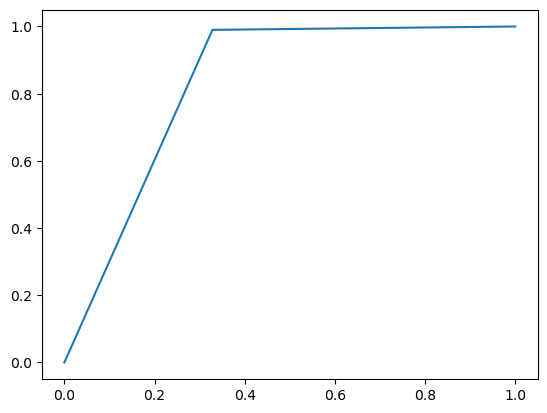

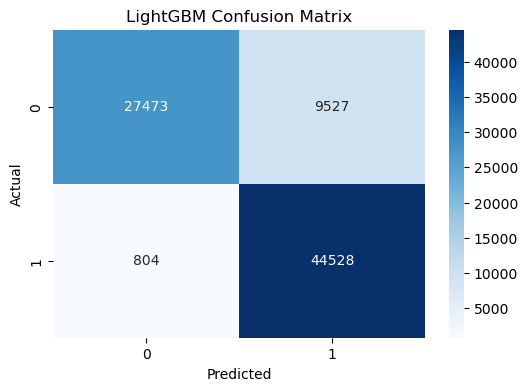


Neural Network Evaluation:
              precision    recall  f1-score   support

           0       0.98      0.62      0.76     37000
           1       0.76      0.99      0.86     45332

    accuracy                           0.82     82332
   macro avg       0.87      0.81      0.81     82332
weighted avg       0.86      0.82      0.82     82332



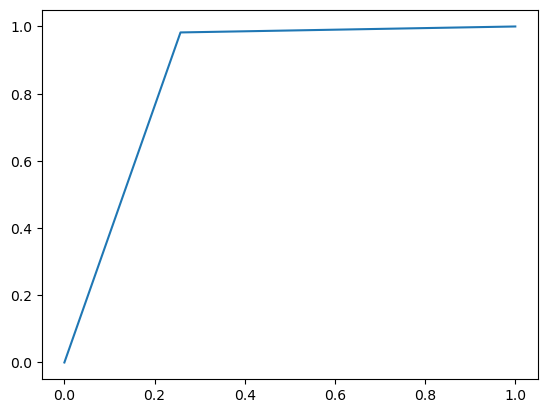

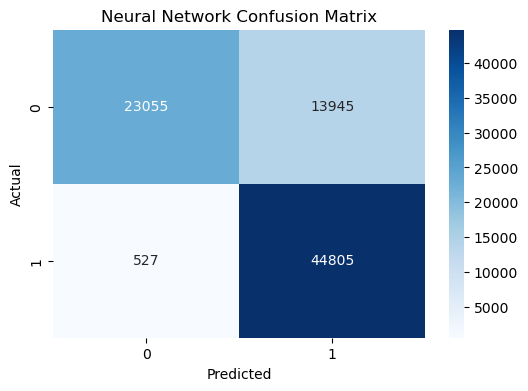

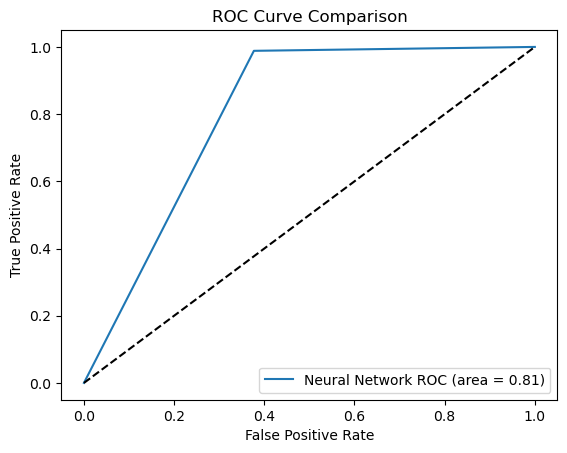

In [11]:
# Initialize plot for ROC curves
plt.figure(figsize=(8, 6))

# Evaluate Random Forest
fpr_rf, tpr_rf, roc_auc_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC (area = %0.2f)' % roc_auc_rf)

# Evaluate XGBoost
fpr_xgb, tpr_xgb, roc_auc_xgb = evaluate_model(y_test, y_pred_xgb, "XGBoost")
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost ROC (area = %0.2f)' % roc_auc_xgb)

# Evaluate LightGBM
fpr_lgb, tpr_lgb, roc_auc_lgb = evaluate_model(y_test, y_pred_lgb, "LightGBM")
plt.plot(fpr_lgb, tpr_lgb, label='LightGBM ROC (area = %0.2f)' % roc_auc_lgb)

# Evaluate Neural Network
fpr_nn, tpr_nn, roc_auc_nn = evaluate_model(y_test, y_pred_nn, "Neural Network")
plt.plot(fpr_nn, tpr_nn, label='Neural Network ROC (area = %0.2f)' % roc_auc_nn)

# Finalize ROC curve plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


### Results

*High Recall for Anomalies*
\
All models demonstrated a high recall for detecting anomalies (Class 1), with values ranging from 0.98 to 0.99. This indicates that the models are proficient at identifying anomalous network traffic, which is crucial for cybersecurity applications where missing an anomaly could have severe consequences.
\
\
*Lower Recall for Normal Traffic*
\
The recall for normal traffic (Class 0) was significantly lower across all models, particularly for the Neural Network and XGBoost classifiers. This suggests that the models are misclassifying a substantial portion of normal traffic as anomalies, leading to a higher false-positive rate.
\
\
*Random Forest and LightGBM Performance*
\
The Random Forest and LightGBM classifiers achieved a better balance between precision and recall for normal traffic compared to the other models. With recalls of 0.76 and 0.74, respectively, they misclassified fewer normal instances as anomalies while maintaining high anomaly detection rates.
\
\
*Overall Accuracy and F1-Scores*
\
The overall accuracy of the models ranged from 0.83 to 0.88, with the Random Forest classifier achieving the highest accuracy. The F1-scores for anomalies were consistently high, reflecting the models' effectiveness in correctly identifying anomalies.